# Aprendizaje Automático y Big Data
## Práctica 1 : Regresión Lineal

Mario Quiñones Pérez y Guillermo García Patiño Lenza


### PARTE 1
### Regresión lineal con una variable

En la primera parte se va encontrar una recta de la forma y = Theta0 + x * Theta1 para aproximar el valor del precio de una vivienda empleando su superficie. 

Para ello, se empleará el método de descenso de gradiente para minimizar el error de la recta con parámetros Theta0 y Theta1 con respecto a los puntos del fichero 'ex1data1.csv' . En este caso, mediremos el error como la media de la suma de los cuadrados de las diferencias entre cada ejemplo proporcionado en el fichero y la estimación de la recta para ese ejemplo

In [1]:
import numpy as np
from pandas.io.parsers import read_csv
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
from mpl_toolkits.mplot3d import Axes3D

def carga_csv(file_name):
    valores = read_csv(file_name, header=None).to_numpy()
    return valores.astype(float)

#### Función de coste:

Esta función calcula cómo de buena es la predicción obtenida por la recta de parámetros T. El objetivo del ejercicio es encontrar los valores de T que minimicen el resultado de esta función

In [2]:
def coste(X, Y, T):
    m = len(X)
    estimacion = T[0] + T[1]*X
    error = estimacion - Y
    i = sum(error**2)
    coste = (1/(2*m))*i
    return coste

#### Implementación iterativa del descenso de gradiente:

A continuación se implementa el método de descenso de gradiente mediante bucles for de python.
Se calcula el valor del parámetro i-ésimo como la diferencia entre el valor actual del parámetro y el producto de alfa (el ratio de aprendizaje) con la suma de los valores de la derivada del coste en función de ese parámetro.

Para conseguir los valores de Theta óptimos que minimizan el valor de la función de coste, se repite este proceso 1500 veces (aunque pueden tomarse otros criterios para determinar que se han obtenido los valores de Theta óptimos, como por ejemplo cuando tras una iteración, la diferencia entre el nuevo error y el anterior es menor que 0.001 )

In [3]:
def calculaHipotesis(datos, a):
    X = datos[:,0]
    Y = datos[:,-1]
    t0 = 0
    t1 = 0
    m = len(X)
    for i in range(1500):
        s0 = s1 = 0
        for i in range(m):
            s0 = s0 + (t0 + t1*X[i] - Y[i])
            s1 = s1 + (t0 + t1*X[i] - Y[i])*X[i]
        t0 = t0 - s0*a/m
        t1 = t1 - s1*a/m
    return (t0, t1)

#### Representación gráfica de la recta obtenida

In [4]:
def main1():
    datos = carga_csv("ex1data1.csv")
    params = calculaHipotesis(datos, 0.01)
    X = datos[:,0]
    Y = datos[:,-1]
    # dibujar grafica
    plt.plot(X, Y, "x")
    min_x = min(X)
    max_x = max(X)
    min_y = params[0] + params[1] * min_x
    max_y = params[0] + params[1] * max_x
    plt.plot([min_x, max_x], [min_y, max_y])
    plt.savefig("resultado.pdf")

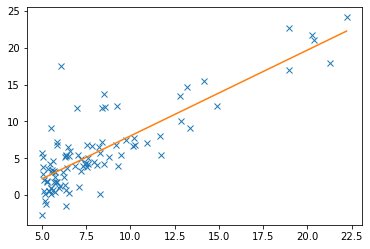

In [143]:
main1()

### 1.1 Visualización de la función de coste

En este apartado se intenta visualizar la evolución de la función de coste para diferentes valores de los parámetros Theta. 

In [5]:
def make_data(t0_range, t1_range, X, Y) :        
    step = 0.1
    Theta0 = np.arange(t0_range[0], t0_range[1], step)
    Theta1 = np.arange(t1_range[0], t1_range[1], step)
    Theta0, Theta1 = np.meshgrid(Theta0, Theta1)
    Coste = np.empty_like(Theta0)
    for ix , iy in np.ndindex(Theta0.shape):
        Coste[ix,iy] = coste(X, Y, [Theta0[ix,iy], Theta1[ix, iy]])
    return [Theta0, Theta1, Coste]

In [6]:
def draw(r):
    plt.contour(r[0], r[1], r[2], np.logspace(-2, 3, 20))
    fig = plt.figure()
    ax = fig.gca(projection='3d')
    surf = ax.plot_surface(r[0], r[1], r[2], cmap=cm.rainbow, linewidth=0,antialiased=False)
    tmp_planes = ax.zaxis._PLANES 
    ax.zaxis._PLANES = ( tmp_planes[2], tmp_planes[3], 
                         tmp_planes[0], tmp_planes[1], 
                         tmp_planes[4], tmp_planes[5])
    ax.view_init(elev=30, azim=220)
    plt.show()

In [7]:
def main11():
    datos = carga_csv("ex1data1.csv")
    X = datos[:,0]
    Y = datos[:,1]
    r = make_data([-10, 10], [-1, 4], X, Y)
    draw(r)

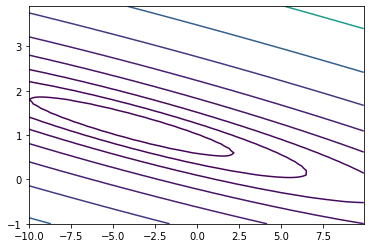

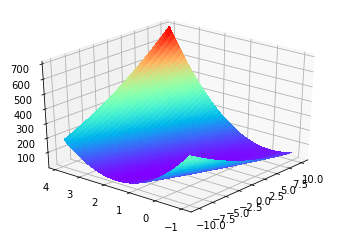

In [147]:
main11()




### PARTE 2
### Regresión con varias variables

### 2.1. Implementación vectorizada del descenso de gradiente

En este apartado se implementa el descenso de gradiente de manera vectorizada. Para hacerlo, puesto que el vector Theta tiene un valor más que el número de atributos de los ejemplares de entrenamiento, se añade a la matriz que contiene los valores de los atributos de los ejemplos una columna llena de 1. 

De esta manera, el vector Theta tiene dimensiones (n,) y la matriz de los atributos tiene (m,n), y se pueden obtener las predicciones para un conjunto de ejemplos simplemente multiplicando ambas matrices, y además la forma de todas las derivadas parciales pasa a ser la misma para todos los parámetros, lo que se puede aprovechar para simplificar también el cálculo del coste

In [8]:
def prepara_datos():
    datos = read_csv("ex1data2.csv", header = None).to_numpy().astype(float)
    X = datos[:, :-1]
    Y = datos[:, -1]
    m = np.shape(X)[0]
    N,med,desv = normalizar(X)
    N2 = np.hstack([np.ones( [m, 1 ] ) , N ] )
    return(N2,Y,med,desv)

#### Normalización de los datos:

Puesto que en el descenso de gradiente se tienen en cuenta los parámetros de cada atributo de manera separada, es posible que la recta que predice los valores de las viviendas en función de su superficie y su número de habitaciones tome la forma precio (y) = Theta0 + Theta1 * superficie + Theta2 * habitaciones con Theta1 >> Theta2 , ya que los valores que se obtienen al trabajar con valores del orden de 10^2 en el descenso de gradiente son mayores que los obtenidos al emplear valores del orden de 10^1. 

Esto causa que uno de los dos atributos tome mayor importancia en la predicción de manera natural. Por ello, se trasladan los valores de los atributos al intervalo [0,1] mediante la función 'normalizar' y se consigue que el descenso de gradiente proporcione valores para los coeficientes de acuerdo a su importancia real

In [9]:
def normalizar(X):
    mu = np.mean(X, axis=0)
    sigma = np.std(X, axis=0)
    X_norm = (X-mu)/sigma
    return(X_norm, mu, sigma)

In [10]:
def coste_2(X, Y, T):
    H = (np.dot(X,T) - Y)**2
    Sum = H.sum()
    m = len(X)
    coste = Sum/(2*m)
    return coste

In [11]:
def descenso_gradiente(X, Y, alpha):
    m = np.shape(X)[1]
    n = np.shape(X)[1]
    T = np.zeros([m,1])
    c = np.empty((1500,))
    p = np.empty((1500,))
    for i in range(1500):
        gradiente(X, Y, T, alpha)
        c[i] = coste_2(X, Y, T)
    return T , c

In [12]:
def gradiente(X, Y, T, alpha):
    TAux = T
    m = np.shape(X)[0]
    n = np.shape(T)[0]
    H = np.dot(X, T)
    np.reshape(Y,(47,1))
    Dif = (np.transpose(H) - Y)
    for j in range(n):
        Dif_j = np.dot(Dif , X[:, j])
        TAux[j] = TAux[j] - (alpha / m) * Dif_j.sum()
    return TAux

#### Influencia del parámetro alfa:

Como ya se ha mencionado antes, en el descanso de gradiente se emplea un parámetro alfa que determina el ritmo al que los parámetros se acercan a su óptimo. Si alfa es demasiado grande, el descenso de gradiente puede no converger y no obtener los parámetros óptimos para Theta, y por el contrario, si alfa es demasiado pequeño, es posible que el descenso de gradiente tarde demasiado en obtener los valores óptimos.

A continuación, se exponen gráficas que muestran la evolución de los valores de la función de coste (eje Y) en cada iteración del descenso de gradiente (eje X), para diferentes valores de alfa.

Se observa que a menor valor de alfa, más tarda el descenso de gradiente en alcanzar valores muy pequeños para los valores del coste, y que para valores del alfa algo mayores (0.3 y 0.1), se obtienen valores pequeños de la función de coste bastante más rápido, aunque en este caso el criterio de parada perjudica a la obtención del mínimo, pues en la gráfica se observa como para estos dos valores la gráfica alcanza valores menores que para el resto y luego toma valores similares. 

In [14]:
def main3():
    X,Y,med,sigma = prepara_datos()
    T = np.zeros([np.shape(X)[1],1])
    T2 = gradiente(X,Y,T,0.1)
    print(T)

In [15]:
main3()

[[34041.26595745]
 [10576.41334928]
 [ 5470.88217559]]


In [153]:
def main2():
    X,Y, med,sigma = prepara_datos()
    P1,c3 = descenso_gradiente(X,Y,0.3)
    P2,c1 = descenso_gradiente(X,Y,0.1)
    P3,c03 = descenso_gradiente(X,Y,0.03)
    P1,c01 = descenso_gradiente(X,Y,0.01)
    P2,c003 = descenso_gradiente(X,Y,0.003)
    P3,c001 = descenso_gradiente(X,Y,0.001)
    val_x = np.arange(0,1500,1)
    plt.figure()
    plt.plot(val_x,c3, c = 'r' , label = ' alfa = 0.3 ')
    plt.plot(val_x,c1, c = 'b' , label = ' alfa = 0.1 ')
    plt.plot(val_x,c01, c = 'g' , label = ' alfa = 0.01 ')
    plt.plot(val_x,c03, c = 'c', label = ' alfa = 0.03 ')
    plt.plot(val_x,c001, c = 'm' , label = ' alfa = 0.001 ')
    plt.plot(val_x,c003, c = 'y' , label = ' alfa = 0.003 ')
    plt.legend()
    plt.savefig('coste_alfa.png')
    plt.show()

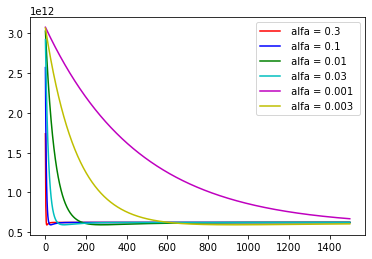

In [154]:
main2()

### 2.2. Ecuación normal

Finalmente, en este último apartado se emplea otro método para obtener los valores óptimos de los parámetros de la recta basados en métodos matemáticos. En este caso, emplear la ecuación normal es más sencillo y efectivo, pues, como se observa posteriormente, obtiene un valor más preciso que el descenso de gradiente. 

Aún así, existen situaciones (si hay muchos ejemplos de entrenamiento), en las que el descenso de gradiente supera a este método en eficiencia.

In [155]:
def ecNormal(datos):
    X = datos[:,:-1]
    Y = datos[:,-1]
    p1 = np.linalg.pinv(np.dot(np.transpose(X), X))
    p2 = np.dot(np.transpose(X),Y)
    params = np.dot(p1,p2)
    return params

In [156]:
def main22():
    datos = carga_csv("ex1data2.csv")
    params = ecNormal(datos)
    print("Theta1:" , params[0], ", Theta2:", params[1])

In [157]:
main22()

Theta1: 140.86108621087715 , Theta2: 16978.191059035016


In [160]:
def main3(cuadrados , habitaciones):
    X1,Y1, med, desv = prepara_datos()
    T_Vector , coste = descenso_gradiente(X1,Y1,0.03)
    T_Normal = ecNormal(datos)
    
    X = datos[:,:-1]
    X_norm, mu, sigma = normaliza(X)
    
    val0 = (1600 - mu[0])/sigma[0]
    val1 = (3 - mu[1]) /sigma[1]
    
    S_V =  (np.dot(np.array([1 ,val0,val1]) , T_Vector)).sum()
    S_N = (np.array([1600,3]) * T_Normal).sum()
    
    print("Para el calculo vectorizado sale:" , S_V.sum())
    print("Para el calculo con la ecuacion normal sale:" , S_N)
    print("La diferencia entre ambos es:" , S_V.sum() - S_N)

In [161]:
main3(1650 , 3)

Para el calculo vectorizado sale: 286120.930670256
Para el calculo con la ecuacion normal sale: 276312.3111145085
La diferencia entre ambos es: 9808.619555747544
